# Urban Demography — GUDD Figures (Clean Version)

**Author:** Andrew Zimmer  
**Created:** 2024-11-14  
**Last Edited:** 2026-02-19  
**Version:** 2.0 (public-facing, cleaned)

This notebook generates Figures 1–4 for the GUDD manuscript, using a consolidated, reproducible, and well-commented workflow. All code is optimized for clarity and public sharing.

**Input Files:**
- `./01_data/04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv`
- `./01_data/04_final_demographic_data/01_static_boundaries/gudd_change_2000_2020_static_boundaries.csv`
- `./01_data/02_auxiliary_data/03_mapping/ne_50m_admin_0_countries.shp`

**Output Files:**
- `./03_documents/01_main_figures/fig1_udr_map.pdf`
- `./03_documents/01_main_figures/fig2_usr_map.pdf`
- `./03_documents/01_main_figures/fig3_citysize_ydr.pdf`
- `./03_documents/01_main_figures/fig4_migration.pdf`

---

## 1. Imports & Global Settings
Import all required libraries and set global plotting and output folder variables.

In [1]:
# 1. Imports & Global Settings
import sys
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
import seaborn as sns

# --- Reproducibility: Print package versions ---
print("Python version:", sys.version)
print("pandas:", pd.__version__)
print("geopandas:", gpd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", mpl.__version__)
print("seaborn:", sns.__version__)

# Set deterministic seed for reproducibility (if needed)
np.random.seed(42)

# Set output and data folders
DATA_FOLDER = Path('../01_data/')
FIGURE_FOLDER = Path('../03_documents/01_main_figures/')

# Ensure output directory exists
os.makedirs(FIGURE_FOLDER, exist_ok=True)

# Set matplotlib global rcParams for consistent style
mpl.rcParams['pdf.fonttype'] = 42  # TrueType fonts for better PDF compatibility
mpl.rcParams['font.family'] = 'DejaVu Sans Mono'
mpl.rcParams['font.size'] = 9
sns.set(style="whitegrid")


Python version: 3.14.2 (main, Dec  5 2025, 16:49:16) [Clang 17.0.0 (clang-1700.6.3.2)]
pandas: 3.0.0
geopandas: 1.1.2
numpy: 2.4.2
matplotlib: 3.10.8
seaborn: 0.13.2


## 2. Load Input Data
Read all required CSVs and shapefiles. Print basic info for verification.

In [2]:
# 2. Load Input Data
# Read main CSVs
gudd_annual_metrics_path = DATA_FOLDER / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv'
gudd_change_path = DATA_FOLDER / '04_final_demographic_data/01_static_boundaries/gudd_change_2000_2020_static_boundaries.csv'
world_shp_path = DATA_FOLDER / '02_auxiliary_data/03_mapping/ne_50m_admin_0_countries.shp'

annual_metrics = pd.read_csv(gudd_annual_metrics_path)
change_data = pd.read_csv(gudd_change_path)
world = gpd.read_file(world_shp_path)

## 3. Data Filtering and Common Preprocessing
Filter to cities present 2000–2020, create filtered DataFrames, and ensure all required columns are present and properly typed.

In [3]:
# 3. Data Filtering and Common Preprocessing
# Filter to cities present for the entire 2000–2020 period
annual_metrics_2020 = annual_metrics[
    (annual_metrics["YearOfBirth"] <= 2000) &
    (annual_metrics["YearOfDeath"] >= 2020) &
    (annual_metrics["year"] == 2020)
].copy()

change_data_filtered = change_data[
    (change_data["YearOfBirth"] <= 2000) &
    (change_data["YearOfDeath"] >= 2020)
].copy()

# Ensure required columns exist and are numeric
def ensure_numeric(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

for df in [annual_metrics_2020, change_data_filtered]:
    ensure_numeric(df, [
        'longitude', 'latitude', 'total_pop_2020', 'total_pop_Delta',
        'total_migration', 'natural_change', 'perc_from_migration'
    ])

# Print summary
print(f"Filtered annual_metrics_2020: {annual_metrics_2020.shape}")
print(f"Filtered change_data: {change_data_filtered.shape}")

Filtered annual_metrics_2020: (8363, 39)
Filtered change_data: (8363, 31)


## 4. Colormaps, Palettes, and Normalization Helpers
Define and register all colormaps and palettes used across figures. Provide helper for truncated colormaps.

In [4]:
# 4. Colormaps, Palettes, and Normalization Helpers

def truncated_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Return a truncated colormap."""
    return mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n)))

# Dependency ratio colormaps
cmap_dr = plt.get_cmap("viridis")
cmap_delta = truncated_colormap(plt.get_cmap("inferno"), 0.1, 0.9)

# Sex ratio colormaps
# WASR
n = 256
blues = mcolors.LinearSegmentedColormap.from_list(
    "custom_blues",
    ["#2c105c",  # deep indigo tail
    "#225ea8",  # strong blue
    "#1fa187",  # viridis teal
    "#9ecae1"   # darker, less rich center blue
    ])(np.linspace(0, 1, n//2))

reds = mcolors.LinearSegmentedColormap.from_list(
    "custom_reds",
    ["#fcbba1",  # darker center red
    "#fb8d3c",  # orange
    "#e31a1c",  # strong red
    "#7a0177"   # deep magenta tail
    ])(np.linspace(0, 1, n//2))

colors = np.vstack([blues, reds])
cmap_sr = mcolors.LinearSegmentedColormap.from_list(
    "sr_balance",
    colors
)

# CHANGE IN WASR
n = 256
greens = mcolors.LinearSegmentedColormap.from_list(
    "custom_greens",
    ["#00441b",  # deep green tail
    "#1fa187",  # viridis-like teal-green
    "#4ac16d",  # rich green
    "#a0e1c7",  # light green-teal
    ])(np.linspace(0, 1, n//2))

pinks = mcolors.LinearSegmentedColormap.from_list(
    "custom_pinks",
    ["#f7b6d2",  # light pink
    "#e164a0",  # strong pink
    "#c51b7d",  # magenta
    "#7a1f4b"   # deep magenta tail
    ])(np.linspace(0, 1, n//2))

colors_delta = np.vstack([greens, pinks])
cmap_delta_sr = mcolors.LinearSegmentedColormap.from_list(
    "sr_delta_balance",
    colors_delta
)
norm_delta_sr = mcolors.TwoSlopeNorm(vmin=-0.05,vcenter=0.0,vmax=0.05)

# Migration custom colormap
migration_colors = [
    '#fdd070', '#fdae61', '#f98e52', '#f46d43', '#e34a33', '#d73027',
    '#c51b7d', '#ae017e', '#8c0273', '#5f0165', '#2b0040'
]
migration_cmap = mcolors.LinearSegmentedColormap.from_list("migration", migration_colors)

# Palettes for boxplots
boxplot_palette = {"2000": "#FFB000", "2020": "#0072B2"}
city_size_order = ["<50k", "50-300k", "300K-1M", "1-5M", ">5M"]

# Normalizations
norm_dr = mpl.colors.Normalize(vmin=0.2, vmax=1.2)
norm_delta = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
norm_migration = mpl.colors.Normalize(vmin=0, vmax=100)

## 5. Font, Layout, and Plotting Utilities
Define font properties, set rcParams, and provide helper functions for formatting, saving, and city size labeling.

In [5]:
# 5. Font, Layout, and Plotting Utilities
# Font properties
mono_font = FontProperties(family="DejaVu Sans Mono", size=9)
label_font = FontProperties(family="DejaVu Sans Mono", size=7)
legend_font = FontProperties(family="DejaVu Sans Mono", size=7)

# Helper: format tick labels for millions
format_millions = lambda y, _: f"{int(y/1e6)}M" if y > 0 else "0"

def safe_savefig(output_path, fig, dpi=300):
    """Save figure to disk with tight bounding box and error handling."""
    try:
        fig.savefig(output_path, format="pdf", bbox_inches='tight', pad_inches=0, dpi=dpi)
        print(f"Saved: {output_path}")
    except Exception as e:
        print(f"Error saving {output_path}: {e}")

def city_size_label(pop):
    """Categorize city size for boxplots and migration panels."""
    if pop <= 50000:
        return "<50k"
    elif pop <= 300000:
        return "50-300k"
    elif pop <= 1000000:
        return "300K-1M"
    elif pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"


## 6. Map Plotting Helpers
Reusable functions for map plotting, region/inset boxes, connectors, and color tweaks.

In [6]:
# 6. Map Plotting Helpers

def darken_color(c, amount=0.6):
    """Darken a matplotlib color by multiplying its RGB components by `amount`."""
    c_rgb = mcolors.to_rgb(c)
    return tuple(np.array(c_rgb) * amount)

def plot_map(ax, data, column, cmap, vmin, vmax, title, letter=None, inset=False, region_box=False, inset_box=False, highlight_points=None):
    """Reusable map plotting function for all map panels."""
    # Basemap
    world.plot(ax=ax, color="#E6E6E6", edgecolor="0.5", linewidth=0.3, zorder=1)
    # Symbol size
    base_size = 8 if inset else 2  # smaller points for inset
    # Normalize colors
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = cmap(norm(data[column]))
    # Slightly darker edge color for each point
    edge_colors = np.array([darken_color(c[:3], 0.6) + (c[3],) for c in rgba_colors])
    # Scatter
    sc = ax.scatter(
        data["longitude"], data["latitude"],
        c=rgba_colors, s=base_size, zorder=2
    )
    # Highlight points
    if highlight_points is not None and len(highlight_points):
        hl_size = 40 if inset else 8
        ax.scatter(
            highlight_points["longitude"], highlight_points["latitude"],
            s=hl_size, facecolor="#ffc425", edgecolor="black", linewidth=0.3, zorder=3, label="Cities Δ > 0.5"
        )
    # Region/inset boxes
    if region_box:
        draw_region_box(ax)
    if inset_box:
        draw_inset_panel_box(ax)
    # Axis limits
    if inset:
        ax.set_xlim(26, 76)
        ax.set_ylim(15, 40)
    else:
        ax.set_xlim(-180, 180)
        ax.set_ylim(-55, 90)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_title(title, fontproperties=mono_font, fontsize=9, pad=4)
    # Subplot letter
    if letter:
        ax.text(0.02, 0.95, letter, transform=ax.transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="top", ha="left", zorder=3)
    return sc, norm

def draw_region_box(ax):
    rect = Rectangle((26, 15), 50, 25, fill=False, linestyle="--", linewidth=0.8, edgecolor="black", zorder=4)
    ax.add_patch(rect)

def draw_inset_panel_box(ax):
    rect = Rectangle((0,0), 1, 1, transform=ax.transAxes, fill=False, linewidth=1, edgecolor="black", zorder=5)
    ax.add_patch(rect)

def connect_axes(fig, ax_main, ax_inset):
    con1 = ConnectionPatch(xyA=(26, 40), coordsA=ax_main.transData, xyB=(0,1), coordsB=ax_inset.transAxes, linestyle="--", linewidth=0.8, color="black")
    con2 = ConnectionPatch(xyA=(76, 40), coordsA=ax_main.transData, xyB=(1,1), coordsB=ax_inset.transAxes, linestyle="--", linewidth=0.8, color="black")
    fig.add_artist(con1)
    fig.add_artist(con2)


## 7. Figure 1 — Global Dependency Ratio Maps
Create 3x2 panel figure for total, young, and old dependency ratios and their changes.

Saved: ../03_documents/01_main_figures/fig1_udr_map.pdf


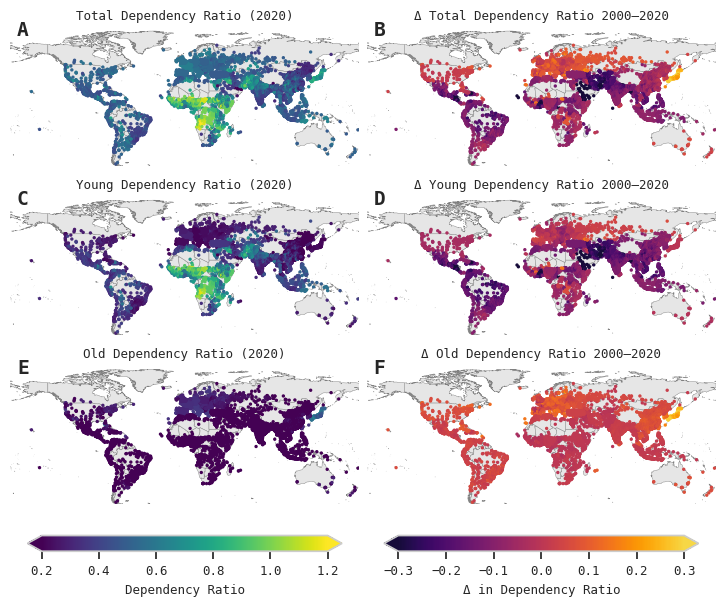

In [7]:
# 7. Figure 1 — Global Dependency Ratio Maps
fig1, axes = plt.subplots(3, 2, figsize=(7.1, 6), constrained_layout=True)
fig1.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0.02, wspace=0.02)
subplot_letters = ["A", "B", "C", "D", "E", "F"]

# Plot each map
sc1, norm1 = plot_map(axes[0,0], annual_metrics_2020, "total_dr", cmap_dr, 0.2, 1.2, "Total Dependency Ratio (2020)", letter=None)
sc2, norm2 = plot_map(axes[0,1], change_data_filtered, "total_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Total Dependency Ratio 2000–2020", letter=None)
sc3, norm3 = plot_map(axes[1,0], annual_metrics_2020, "young_dr", cmap_dr, 0.2, 1.2, "Young Dependency Ratio (2020)", letter=None)
sc4, norm4 = plot_map(axes[1,1], change_data_filtered, "young_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Young Dependency Ratio 2000–2020", letter=None)
sc5, norm5 = plot_map(axes[2,0], annual_metrics_2020, "old_dr", cmap_dr, 0.2, 1.2, "Old Dependency Ratio (2020)", letter=None)
sc6, norm6 = plot_map(axes[2,1], change_data_filtered, "old_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Old Dependency Ratio 2000–2020", letter=None)

# Move subplot letters up a bit
letter_y = 0.9
for ax, letter in zip(axes.flat, subplot_letters):
    ax.text(0.02, letter_y, letter, transform=ax.transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)

# Colorbars
cbar1 = fig1.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap_dr), ax=axes[:,0], orientation="horizontal", fraction=0.04, pad=0.06, shrink=0.9, extend='both')
cbar2 = fig1.colorbar(plt.cm.ScalarMappable(norm=norm2, cmap=cmap_delta), ax=axes[:,1], orientation="horizontal", fraction=0.04, pad=0.06, shrink=0.9, extend='both')

# Colorbar labels and ticks
for cbar, label in zip([cbar1, cbar2], ["Dependency Ratio", "Δ in Dependency Ratio"]):
    cbar.ax.set_xlabel(label, fontproperties=mono_font)
    for tick in cbar.ax.get_xticklabels():
        tick.set_fontproperties(mono_font)

# Save figure
fig1_path = FIGURE_FOLDER / 'fig1_udr_map.pdf'
safe_savefig(fig1_path, fig1)
plt.show()

## 8. Figure 2 — Working-Age Sex Ratio (Main + Arabia Inset)
Create 2x2 panel figure with main world maps and Arabia inset, including highlight points and connectors.

Saved: ../03_documents/01_main_figures/fig2_usr_map.pdf


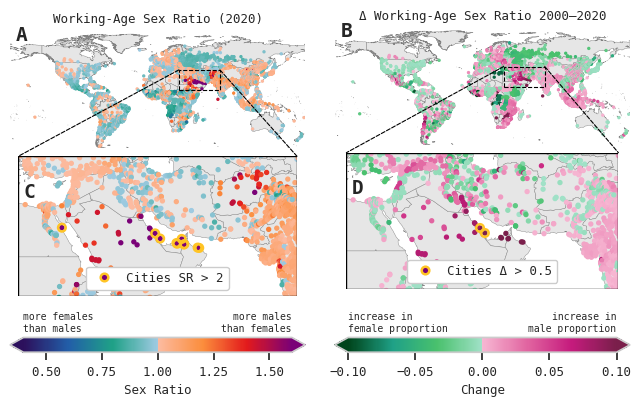

In [8]:
highlight = change_data_filtered[change_data_filtered["working_sr_Delta"] > 0.5]
highlight_sr = annual_metrics_2020[annual_metrics_2020["working_sr"] > 2]

fig2, axes = plt.subplots(
    2, 2, figsize=(8, 4.5), gridspec_kw={'hspace': 0.06, 'wspace': 0.1}
)

# Main maps
sc1,_ = plot_map(axes[0,0], annual_metrics_2020, "working_sr", cmap_sr, 0.4, 1.6, "Working-Age Sex Ratio (2020)", region_box=True)
vmin_delta, vmax_delta = -0.1, 0.1
sc2,_ = plot_map(axes[0,1], change_data_filtered, "working_sr_Delta", cmap_delta_sr, vmin_delta, vmax_delta, "Δ Working-Age Sex Ratio 2000–2020", region_box=True)

# Insets
sc3,_ = plot_map(axes[1,0], annual_metrics_2020, "working_sr", cmap_sr, 0.4, 1.6, "", inset=True, inset_box=True)
sc4,_ = plot_map(axes[1,1], change_data_filtered, "working_sr_Delta", cmap_delta_sr, vmin_delta, vmax_delta, "", inset=True, inset_box=True)

# Highlight settings
highlight_outline_color = "#ffc425"
highlight_size = 30
highlight_outline_width_main = 0    # thinner for main map
highlight_outline_width_inset = 1.8   # thicker for inset
legend_fill_color = "#7a0177"

def add_highlight_outline(ax, df, size, linewidth):
    if len(df) == 0: 
        return
    ax.scatter(
        df["longitude"], df["latitude"],
        s=size, facecolors="none",
        edgecolors=highlight_outline_color,
        linewidths=linewidth, zorder=5
    )

# Apply different widths to main vs inset maps
for ax, df, lw in zip(
    [axes[0,0], axes[1,0], axes[0,1], axes[1,1]],
    [highlight_sr, highlight_sr, highlight, highlight],
    [highlight_outline_width_main, highlight_outline_width_inset,
     highlight_outline_width_main, highlight_outline_width_inset]
):
    add_highlight_outline(ax, df, highlight_size, lw)

# Panel labels
for r, c, y, l in [(0,0,0.9,"A"), (0,1,0.9,"B"), (1,0,0.7,"C"), (1,1,0.7,"D")]:
    axes[r,c].text(0.02, y, l, transform=axes[r,c].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold")

# Connect main maps to insets
connect_axes(fig2, axes[0,0], axes[1,0])
connect_axes(fig2, axes[0,1], axes[1,1])

# Colorbars
cbar1 = fig2.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(0.4,1.6), cmap=cmap_sr),
    ax=[axes[0,0], axes[1,0]], orientation="horizontal",
    fraction=0.05, pad=0.12, extend="both"
)
cbar1.set_label("Sex Ratio", fontproperties=mono_font)
for t in cbar1.ax.get_xticklabels(): 
    t.set_fontproperties(mono_font)
cbar1.ax.text(0,1.4,"more females\nthan males", transform=cbar1.ax.transAxes, ha="left", fontproperties=mono_font, fontsize=7)
cbar1.ax.text(1,1.4,"more males\nthan females", transform=cbar1.ax.transAxes, ha="right", fontproperties=mono_font, fontsize=7)

cbar2 = fig2.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin_delta,vmax_delta), cmap=cmap_delta_sr),
    ax=[axes[0,1], axes[1,1]], orientation="horizontal",
    fraction=0.05, pad=0.14, extend="both"
)
cbar2.set_label("Change", fontproperties=mono_font)
for t in cbar2.ax.get_xticklabels(): 
    t.set_fontproperties(mono_font)
cbar2.ax.text(0,1.4,"increase in\nfemale proportion", transform=cbar2.ax.transAxes, ha="left", fontproperties=mono_font, fontsize=7)
cbar2.ax.text(1,1.4,"increase in\nmale proportion", transform=cbar2.ax.transAxes, ha="right", fontproperties=mono_font, fontsize=7)

# Legends
from matplotlib.lines import Line2D
legend_marker_size = np.sqrt(highlight_size)
legend_items = [
    Line2D([0],[0], marker='o', linestyle='None', markerfacecolor=legend_fill_color,
           markeredgecolor=highlight_outline_color, markeredgewidth=highlight_outline_width_inset,
           markersize=legend_marker_size, label="Cities SR > 2"),
    Line2D([0],[0], marker='o', linestyle='None', markerfacecolor=legend_fill_color,
           markeredgecolor=highlight_outline_color, markeredgewidth=highlight_outline_width_inset,
           markersize=legend_marker_size, label="Cities Δ > 0.5")
]
if len(highlight_sr): axes[1,0].legend(handles=[legend_items[0]], prop=mono_font, fontsize=8, framealpha=1)
if len(highlight): axes[1,1].legend(handles=[legend_items[1]], prop=mono_font, fontsize=8, framealpha=1)

# Save
fig2_path = FIGURE_FOLDER/"fig2_usr_map.pdf"
safe_savefig(fig2_path, fig2)
plt.show()

## 9. Figure 3 — Boxplot of Young Dependency Ratio by City Size
Prepare data and plot main and facet boxplots for YDR by city size and continent group.

Saved: ../03_documents/01_main_figures/fig3_citysize_ydr.pdf


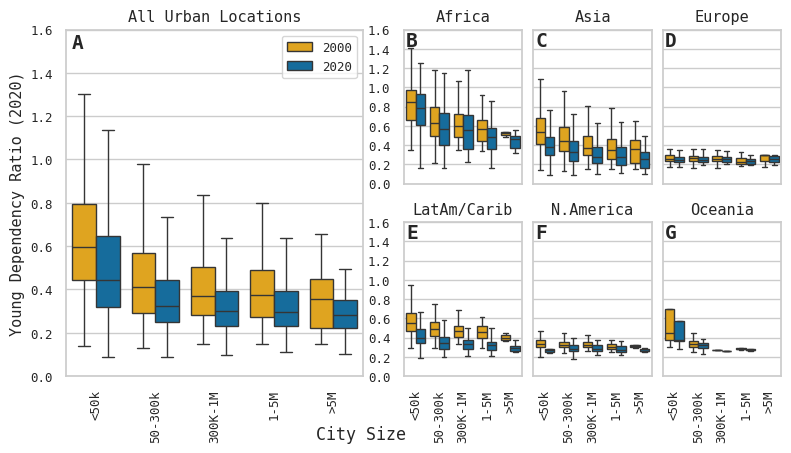

In [9]:
# 9. Figure 3 — Boxplot of Young Dependency Ratio by City Size
# Data prep
boxplot_data = annual_metrics[[
    'ID_UC_G0', 'year', 'young_dr', 'total_pop', 'Continent'
]].copy()
boxplot_data = boxplot_data[(boxplot_data['year'].isin([2000, 2020])) & (boxplot_data['Continent'] != "#N/A")]
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
boxplot_data['ContinentGroup'] = boxplot_data['Continent'].map(continent_map)
boxplot_data = boxplot_data.dropna(subset=['ContinentGroup'])
boxplot_data['CitySize'] = pd.Categorical(
    boxplot_data['total_pop'].apply(city_size_label),
    categories=city_size_order, ordered=True
)
boxplot_data['year'] = boxplot_data['year'].astype(str)
continent_groups = ["Africa", "Asia", "Europe", "LatAm/Carib", "N.America", "Oceania"]

# Figure setup
fig3 = plt.figure(figsize=(10,4.5))
gs = GridSpec(2, 4, figure=fig3, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1], wspace=0.25, hspace=0.25)

# Big plot (double height)
ax_big = fig3.add_subplot(gs[:,0])
sns.boxplot(
    data=boxplot_data, x='CitySize', y='young_dr', hue='year', palette=boxplot_palette,
    dodge=True, linewidth=1, fliersize=0, showfliers=False, ax=ax_big
)
ax_big.set_ylabel("Young Dependency Ratio (2020)", fontproperties=mono_font, fontsize=11)
ax_big.set_title("All Urban Locations", fontproperties=mono_font, fontsize=11)
ax_big.set_ylim(0,1.6)
ax_big.set_yticks([i*0.2 for i in range(9)])
ax_big.tick_params(axis='x', rotation=90, labelsize=9)
ax_big.set_xlabel(None)
for tick in ax_big.get_yticklabels() + ax_big.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(9)
handles, labels = ax_big.get_legend_handles_labels()
ax_big.legend(handles, labels, title="", prop=mono_font, loc='upper right', fontsize=9)

# Right-hand 3x2 plots
small_axes = []
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig3.add_subplot(gs[row, col+1])
    small_axes.append(ax)
    cont_data = boxplot_data[boxplot_data['ContinentGroup'] == cont]
    sns.boxplot(
        data=cont_data, x='CitySize', y='young_dr', hue='year', palette=boxplot_palette,
        dodge=True, linewidth=1, fliersize=0, showfliers=False, ax=ax
    )
    ax.set_title(cont, fontproperties=mono_font, fontsize=11)
    ax.set_xlabel(None)
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=9, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    if col != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("", fontproperties=mono_font, fontsize=11)
    ax.set_ylim(0,1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    for tick in ax.get_yticklabels() + ax.get_xticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(9)
    ax.get_legend().remove()

# Adjust horizontal gaps
for i, ax in enumerate(small_axes):
    pos = ax.get_position()
    col = i % 3
    if col == 0:
        ax.set_position([pos.x0 + 0, pos.y0, pos.width, pos.height])
    elif col == 1:
        ax.set_position([pos.x0 -0.03, pos.y0, pos.width, pos.height])
    elif col == 2:
        ax.set_position([pos.x0 - 0.06, pos.y0, pos.width, pos.height])

# Subplot letters
subplot_letters = ['A','B','C','D','E','F','G']
all_axes = [ax_big] + small_axes
for ax, letter in zip(all_axes, subplot_letters):
    ax.text(0.02, 0.99, letter, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', fontproperties=mono_font)

# Single x-axis label under figure
fig3.text(0.42, -0.03, "City Size", fontproperties=mono_font, fontsize=12, ha='center')

# Save figure
fig3_path = FIGURE_FOLDER / 'fig3_citysize_ydr.pdf'
safe_savefig(fig3_path, fig3)
plt.show()

## 10. Figure 4 — Net Migration vs Natural Change
Consolidated setup and plotting for migration/natural change panels, using preferred final plotting style.

Saved: ../03_documents/01_main_figures/fig4_migration.pdf


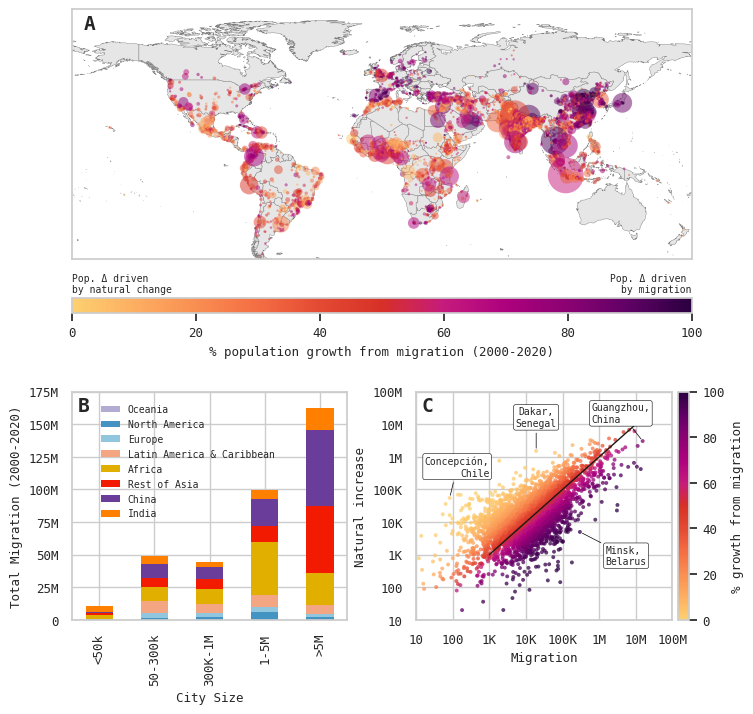

In [11]:
# 10. Figure 4 — Net Migration vs Natural Change
# Setup: continent mapping, city size, and label specs
continent_map_mig = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'Latin America and the Caribbean',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Rest of Asia',
    'Eastern and South-Eastern Asia': 'Rest of Asia',
    'Northern America': 'North America'
}

migration_map_data = change_data_filtered.copy()
migration_map_data = migration_map_data[(migration_map_data["total_migration"] > 0) & (migration_map_data["natural_change"] > 0)].copy()
migration_map_data["Continent"] = migration_map_data["Continent"].map(continent_map_mig)
migration_map_data.loc[migration_map_data["Country"]=="China","Continent"]="China"
migration_map_data.loc[migration_map_data["Country"]=="India","Continent"]="India"
migration_map_data["CitySize"] = pd.Categorical(
    migration_map_data["total_pop_2020"].apply(city_size_label),
    categories=city_size_order, ordered=True
)

# Stacked bar data
continent_order = ["Oceania", "North America", "Europe", "Latin America and the Caribbean", "Africa", "Rest of Asia", "China", "India"]
stacked_data = migration_map_data.groupby(["CitySize","Continent"],as_index=False)["total_migration"].sum()
stacked_data = stacked_data[stacked_data["Continent"].isin(continent_order)]
stacked_pivot = stacked_data.pivot_table(index="CitySize", columns="Continent", values="total_migration", fill_value=0).reindex(index=city_size_order,columns=continent_order)

# Label specs for selected cities
label_specs = {
    ("Guangzhou", "China"): {"xmult": 0.04, "ymult": 10.0, "ha": "left", "va": "bottom"},
    ("Dakar", "Senegal"): {"xmult": 1.0, "ymult": 5.0, "ha": "center", "va": "bottom"},
    ("Minsk", "Belarus"): {"xmult": 5.0, "ymult": 0.4, "ha": "left", "va": "top"},
    ("Concepción", "Chile"): {"xmult": 1, "ymult": 20.0, "ha": "right", "va": "top"},
}

fig4 = plt.figure(figsize=(8,8))
gs = GridSpec(2,2, height_ratios=[1.4,1], hspace=0.25, wspace=0.25)
subplot_labels = ['A','B','C']

# PANEL A - Map
ax_map = fig4.add_subplot(gs[0,:])
sizes = np.interp(migration_map_data["total_pop_Delta"], (migration_map_data["total_pop_Delta"].min(), migration_map_data["total_pop_Delta"].max()), (2,800))
# Plot points first, then world outlines
sc_map = ax_map.scatter(
    migration_map_data.longitude, migration_map_data.latitude,
    c=migration_map_data.perc_from_migration, cmap=migration_cmap, norm=norm_migration,
    s=sizes, edgecolor="black", linewidth=0, alpha=0.5, zorder=2)
world.plot(ax=ax_map, color="#E6E6E6", edgecolor="0.5", linewidth=0.3, zorder=1)
ax_map.set_xlim(-180,180)
ax_map.set_ylim(-55,90)
ax_map.set_xticks([])
ax_map.set_yticks([])
sm_map = plt.cm.ScalarMappable(cmap=migration_cmap, norm=norm_migration)
sm_map.set_array([])
cbar = fig4.colorbar(sm_map, ax=ax_map, orientation="horizontal", fraction=0.08, pad=0.12, aspect=40)
cbar.set_label("% population growth from migration (2000-2020)", fontproperties=mono_font)
for tick in cbar.ax.get_xticklabels(): tick.set_fontproperties(mono_font)
cbar.ax.text(0.0, 1.2, "Pop. Δ driven \nby natural change", ha='left', va='bottom', transform=cbar.ax.transAxes, fontproperties=mono_font, fontsize = 7)
cbar.ax.text(1.0, 1.2, "Pop. Δ driven \nby migration", ha='right', va='bottom', transform=cbar.ax.transAxes, fontproperties=mono_font, fontsize = 7)

# PANEL B - Stacked bar
ax_bar = fig4.add_subplot(gs[1,0])
# Custom color order: Africa (mustard), Rest of Asia (pink/red), China (purple), India (orange), others shifted
bar_colors = [
    '#B2ABD2',  # Oceania (light purple)
    '#4393C3',  # North America (blue)
    '#92C5DE',  # Europe (light blue)
    '#F4A582',  # LatAm/Carib (peach)
    '#E1AF00',  # Africa (mustard)
    '#F21A00',  # Rest of Asia (pink/red)
    '#6A3D9A',  # China (purple)
    '#FF7F00',  # India (orange)
]
stacked_pivot.plot(kind="bar", stacked=True, ax=ax_bar, linewidth=0, color=bar_colors)
ax_bar.set_ylabel("Total Migration (2000-2020)", fontproperties=mono_font)
ax_bar.set_xlabel("City Size", fontproperties=mono_font)
yticks = ax_bar.get_yticks()
ax_bar.set_yticks(yticks)
ax_bar.set_yticklabels([f"{int(y/1e6)}M" if y>0 else "0" for y in yticks], fontproperties=mono_font)
for tick in ax_bar.get_xticklabels(): tick.set_fontproperties(mono_font)
handles, legend_labels = ax_bar.get_legend_handles_labels()
legend_labels = ["Latin America & Caribbean" if lab == "Latin America and the Caribbean" else lab for lab in legend_labels]
fig4.legend(handles, legend_labels, prop=legend_font, frameon=False, loc="upper left", bbox_to_anchor=(0.15,0.39))
ax_bar.get_legend().remove()

# PANEL C - Scatter
ax_scatter = fig4.add_subplot(gs[1,1])
sc = ax_scatter.scatter(
    migration_map_data["total_migration"], migration_map_data["natural_change"],
    c=migration_map_data["perc_from_migration"], cmap=migration_cmap, norm=norm_migration,
    s=8, edgecolor="black", linewidth=0, alpha=0.75)
ax_scatter.set_xscale("log")
ax_scatter.set_yscale("log")
lims = [1e3,1e7]
ax_scatter.set_xlim(lims)
ax_scatter.set_ylim(lims)
# 1:1 line, solid, no alpha
ax_scatter.plot(lims, lims, linestyle="-", linewidth=1, color="k", alpha=1.0, zorder=1)
ticks = [10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
labels = ["10","100","1K","10K","100K","1M","10M","100M"]
ax_scatter.set_xticks(ticks)
ax_scatter.set_xticklabels(labels,fontproperties=mono_font)
ax_scatter.set_yticks(ticks)
ax_scatter.set_yticklabels(labels,fontproperties=mono_font)
ax_scatter.set_xlabel("Migration",fontproperties=mono_font)
ax_scatter.set_ylabel("Natural increase",fontproperties=mono_font)
# Colorbar for scatter: fully opaque
sm_scatter = plt.cm.ScalarMappable(cmap=migration_cmap, norm=norm_migration)
sm_scatter.set_array([])
cbar2 = fig4.colorbar(sm_scatter, ax=ax_scatter, fraction=0.05, pad=0.02)
for tick in cbar2.ax.get_yticklabels(): tick.set_fontproperties(mono_font)
for tick in cbar2.ax.get_xticklabels(): tick.set_fontproperties(mono_font)
cbar2.set_label("% growth from migration", fontproperties=mono_font)
# Label selected cities, keep labels within bounds
for (name, country), spec in label_specs.items():
    row = migration_map_data[(migration_map_data["Name"] == name) & (migration_map_data["Country"] == country)]
    if row.empty: continue
    x = row["total_migration"].values[0]
    y = row["natural_change"].values[0]
    # Adjust label position to keep within axis bounds
    x_text = np.clip(x * spec["xmult"], lims[0], lims[1])
    y_text = np.clip(y * spec["ymult"], lims[0], lims[1])
    label_text = f"{name},\n{country}"
    ax_scatter.annotate(
        label_text, xy=(x, y), xytext=(x_text, y_text), textcoords="data",
        arrowprops=dict(arrowstyle="-", linewidth=0.5, color="black"),
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", linewidth=0.4),
        fontproperties=label_font, ha=spec["ha"], va=spec["va"])
# Panel labels
for ax, label in zip([ax_map, ax_bar, ax_scatter], subplot_labels):
    ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', fontproperties=mono_font)
# Save figure
fig4_path = FIGURE_FOLDER / 'fig4_migration.pdf'
safe_savefig(fig4_path, fig4)
plt.show()
